# LineageOT benchmark

In [1]:
# pip install git+https://github.com/aforr/LineageOT@master cvxopt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from ott.geometry.pointcloud import PointCloud
from jax import numpy as jnp
import seaborn as sns

from time import perf_counter
from moscot import FusedGW
import pickle

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ot

import lineageot.simulation as sim
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf

from typing import Literal, Optional, Sequence, Dict
import traceback
from collections import namedtuple, defaultdict

In [4]:
bnt = namedtuple("bnt", "tmat early_cost late_cost norm_diff converged time")
stn = namedtuple("sim",
                 "sim_info "
                 "ancestor_info "
                 "rna_arrays "
                 "true_coupling "
                 "true_distances "
                 "fitted_tree_distances_late "
                 "hamming_distances_late "
                 "early_time_rna_cost "
                 "late_time_rna_cost")

In [5]:
def init_sim(flow_type: Literal['bifurcation', 'convergent', 'partial_convergent', 'mistmatched_clusters'],
             seed: int = 257, plot: bool = True, **kwargs):
    start = perf_counter()
    np.random.seed(seed) 
    if flow_type == 'bifurcation':
        timescale = 1
    else:
        timescale = 100

    x0_speed = 1/timescale
    sim_params = sim.SimulationParameters(division_time_std = 0.01*timescale,
                                          flow_type = flow_type,
                                          x0_speed = x0_speed,
                                          mutation_rate = 1/timescale,
                                          mean_division_time = 1.1*timescale,
                                          timestep = 0.001*timescale,
                                          **kwargs)

    # These parameters can be adjusted freely.
    # As is, they replicate the plots in the paper for the fully convergent simulation.
    mean_x0_early = 2
    time_early = 7.4*timescale # Time when early cells are sampled
    time_late = time_early + 4*timescale # Time when late cells are sampled
    x0_initial = mean_x0_early -time_early*x0_speed
    initial_cell = sim.Cell(np.array([x0_initial, 0, 0]), np.zeros(sim_params.barcode_length))
    sample_times = {'early' : time_early, 'late' : time_late}



    # Choosing which of the three dimensions to show in later plots
    if flow_type == 'mismatched_clusters':
        dimensions_to_plot = [1, 2]
    else:
        dimensions_to_plot = [0, 1]

    ## Running the simulation
    sample = sim.sample_descendants(initial_cell.deepcopy(), time_late, sim_params)

    # Extracting trees and barcode matrices
    true_trees = {'late': sim_inf.list_tree_to_digraph(sample)}
    true_trees['late'].nodes['root']['cell'] = initial_cell
    true_trees['early'] = sim_inf.truncate_tree(true_trees['late'], sample_times['early'], sim_params)

    # Computing the ground-truth coupling
    true_coupling = sim_inf.get_true_coupling(true_trees['early'], true_trees['late'])
    
    data_arrays = {'late': sim_inf.extract_data_arrays(true_trees['late'])}
    rna_arrays = {'late': data_arrays['late'][0]}
    barcode_arrays = {'late': data_arrays['late'][1]}

    rna_arrays['early'] = sim_inf.extract_data_arrays(true_trees['early'])[0]
    num_cells = {'early': rna_arrays['early'].shape[0], 'late': rna_arrays['late'].shape[0]}

    print("Times:", sample_times)
    print("Number of cells:", num_cells)
    
        # Creating a copy of the true tree for use in LineageOT
    true_trees['late, annotated'] = copy.deepcopy(true_trees['late'])
    sim_inf.add_node_times_from_division_times(true_trees['late, annotated'])

    sim_inf.add_nodes_at_time(true_trees['late, annotated'], sample_times['early'])
    
    if plot:
        # Scatter plot of cell states
        cmap = "coolwarm"
        colors = [plt.get_cmap(cmap)(0), plt.get_cmap(cmap)(256)]
        for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
            plt.scatter(a[:, dimensions_to_plot[0]],
                        a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

        plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
        plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
        plt.legend()
        
    # Infer ancestor locations for the late cells based on the true lineage tree
    observed_nodes = [n for n in sim_inf.get_leaves(true_trees['late, annotated'], include_root=False)]
    sim_inf.add_conditional_means_and_variances(true_trees['late, annotated'], observed_nodes)

    ancestor_info = {'true tree': sim_inf.get_ancestor_data(true_trees['late, annotated'], sample_times['early'])}
    
    # True distances
    true_distances = {key: sim_inf.compute_tree_distances(true_trees[key]) for key in true_trees}
    
    rate_estimate = sim_inf.rate_estimator(barcode_arrays['late'], sample_times['late'])

    print("Fraction unmutated barcodes: ", {key:np.sum(barcode_arrays[key] == 0)/barcode_arrays[key].size
                                            for key in barcode_arrays})
    print("Rate estimate: ", rate_estimate)
    print("True rate: ", sim_params.mutation_rate / sim_params.barcode_length)
    print("Rate accuracy: ", rate_estimate*sim_params.barcode_length/sim_params.mutation_rate)
    
    # Compute Hamming distance matrices for neighbor joining

    hamming_distances_with_roots = {
        'late': sim_inf.barcode_distances(np.concatenate([barcode_arrays['late'],
                                                          np.zeros([1,sim_params.barcode_length])]))
    }
    fitted_tree = sim_inf.neighbor_join(hamming_distances_with_roots['late'])
    fitted_tree_distances = sim_inf.compute_tree_distances(fitted_tree)
    hamming_distances_late = hamming_distances_with_roots['late'][np.triu_indices(num_cells['late'])] / rate_estimate
    
    # Annotate fitted tree with internal node times

    sim_inf.add_leaf_barcodes(fitted_tree, barcode_arrays['late'])
    sim_inf.add_leaf_x(fitted_tree, rna_arrays['late'])
    sim_inf.add_leaf_times(fitted_tree, sample_times['late'])
    sim_inf.annotate_tree(fitted_tree,
                          rate_estimate*np.ones(sim_params.barcode_length),
                          time_inference_method = 'least_squares')
    
    # Add inferred ancestor nodes and states
    sim_inf.add_node_times_from_division_times(fitted_tree)
    sim_inf.add_nodes_at_time(fitted_tree, sample_times['early'])
    observed_nodes = [n for n in sim_inf.get_leaves(fitted_tree, include_root = False)]
    sim_inf.add_conditional_means_and_variances(fitted_tree, observed_nodes)
    ancestor_info['fitted tree'] = sim_inf.get_ancestor_data(fitted_tree, sample_times['early'])

    end = perf_counter() - start
    print(f"Time: {end}")
    
    early_time_rna_cost = ot.utils.dist(rna_arrays['early'], sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0])
    late_time_rna_cost = ot.utils.dist(rna_arrays['late'], rna_arrays['late'])
    
    return stn(sim_inf, ancestor_info, rna_arrays, true_coupling, true_distances,
               fitted_tree_distances, hamming_distances_late, early_time_rna_cost,
               late_time_rna_cost)

In [6]:
def benchmark_moscot(sim: stn, *, alpha: float, epsilon: Optional[float] = None, rescale: bool = True, **kwargs):
    def create_geometry(cost_matrix: np.ndarray) -> Geometry:
        cost_matrix = jnp.array(cost_matrix)
        if rescale:
            cost_matrix /= cost_matrix.max()
            assert cost_matrix.max() == 1.0
        assert (cost_matrix >= 0).all()
        return Geometry(cost_matrix=cost_matrix)
    
    e = create_geometry(sim.true_distances['early'])
    l = create_geometry(sim.true_distances['late'])
    joint = create_geometry(ot.utils.dist(sim.rna_arrays['early'], sim.rna_arrays['late']))
    
    max_iterations = kwargs.pop("max_iterations", 20)
    rtol = kwargs.pop("rtol", 1e-6)
    atol = kwargs.pop("atol", 1e-6)
    
    fgw = FusedGW(alpha=alpha, epsilon=epsilon, **kwargs)
    start = perf_counter()
    fgw.fit(e, l, joint, linesearch=False, verbose=False, max_iterations=max_iterations, rtol=rtol, atol=atol)
    time = perf_counter() - start
    tmat = np.array(fgw.matrix)
    print(f"Time: {time}")
    
    early_cost = float(sim.sim_info.OT_cost(tmat, sim.early_time_rna_cost))
    late_cost = float(sim.sim_info.OT_cost(sim_eval.expand_coupling(tmat, sim.true_coupling, sim.late_time_rna_cost),
                                          sim.late_time_rna_cost))
    norm_diff = np.linalg.norm(tmat - sim.true_coupling)
        
    return bnt(tmat, early_cost, late_cost, norm_diff, fgw.converged_sinkhorn, time)

In [7]:
def gridsearch(sim: stn, *, alphas: Sequence[float], epsilons: Sequence[float], rescale: bool = True, **kwargs) -> Dict[float, Dict[float, bnt]]:
    res = defaultdict(defaultdict)
    for alpha in alphas:
        for epsilon in epsilons:
            try:
                print(f"alpha={alpha}, epsilon={epsilon}")
                res[alpha][epsilon] = benchmark_moscot(sim, alpha=alpha, epsilon=epsilon, rescale=rescale, **kwargs)
            except Exception as e:
                print(traceback.format_exc())
                res[alpha][epsilon] = None
    
    return {a: {e: v for e, v in vs.items()} for a, vs in res.items()}

In [8]:
def plot(res, suptitle="", figsize=(12, 3), dpi=300):
    vals = {
        "early_cost": defaultdict(defaultdict),
        "late_cost": defaultdict(defaultdict),
        "norm_diff": defaultdict(defaultdict),
        "time": defaultdict(defaultdict),
    }
    
    for alpha, vs in res.items():
        for epsilon, bench in vs.items():
            for attr, container in vals.items():
                container[alpha][epsilon] = getattr(res[alpha][epsilon], attr)
                
    fig, axes = plt.subplots(1, 4, tight_layout=True, dpi=dpi, figsize=figsize)
    fig.suptitle(flow_type)
    axes = np.ravel([axes])
    
    for ax, (attr, val) in zip(axes, vals.items()):
        data = pd.DataFrame(val)
        sns.heatmap(data, ax=ax, annot=True, fmt='.3g', cmap='viridis')
        ax.set_title(attr)
        ax.set_xlabel("alpha")
        ax.set_ylabel("epsilon")
        
    fig.savefig(f"{suptitle}.pdf")

In [9]:
sim_params = {}
# original epsilons
epsilons = np.logspace(-2, 3, 15)
alphas = np.linspace(0.025, 0.975, 20)
print(epsilons)
print(alphas)

[0.01]
[0.025]


Times: {'early': 7.4, 'late': 11.4}
Number of cells: {'early': 64, 'late': 1024}
Fraction unmutated barcodes:  {'late': 0.47311197916666664}
Rate estimate:  0.06565115579693222
True rate:  0.06666666666666667
Rate accuracy:  0.9847673369539832
     pcost       dcost       gap    pres   dres
 0: -6.3033e+04 -6.5712e+04  2e+04  3e-01  3e-01
 1: -6.2703e+04 -6.8508e+04  1e+04  9e-02  1e-01
 2: -6.2500e+04 -6.6193e+04  4e+03  3e-02  3e-02
 3: -6.2907e+04 -6.4419e+04  2e+03  1e-02  1e-02
 4: -6.2914e+04 -6.4359e+04  2e+03  8e-03  9e-03
 5: -6.3065e+04 -6.3855e+04  8e+02  3e-03  3e-03
 6: -6.3152e+04 -6.3566e+04  4e+02  1e-16  2e-16
 7: -6.3240e+04 -6.3320e+04  8e+01  1e-16  3e-16
 8: -6.3259e+04 -6.3266e+04  8e+00  1e-16  4e-16
 9: -6.3260e+04 -6.3261e+04  4e-01  1e-16  5e-16
10: -6.3261e+04 -6.3261e+04  1e-02  1e-16  7e-16
Optimal solution found.
Time: 182.58878891199856


alpha=0.025, epsilon=0.01
Time: 3.2511784399976023
Times: {'early': 740.0, 'late': 1140.0}
Number of cells: {'early': 64, 'late': 1024}
Fraction unmutated barcodes:  {'late': 0.47311197916666664}
Rate estimate:  0.0006565115579693221
True rate:  0.0006666666666666666
Rate accuracy:  0.9847673369539832
     pcost       dcost       gap    pres   dres
 0: -6.3033e+08 -6.5015e+08  1e+08  2e-01  2e-01
 1: -6.2945e+08 -6.6103e+08  4e+07  4e-02  6e-02
 2: -6.2910e+08 -6.4660e+08  2e+07  1e-02  2e-02
 3: -6.3080e+08 -6.3880e+08  8e+06  4e-03  6e-03
 4: -6.3112e+08 -6.3682e+08  6e+06  3e-04  5e-04
 5: -6.3180e+08 -6.3502e+08  3e+06  1e-04  2e-04
 6: -6.3224e+08 -6.3378e+08  2e+06  3e-05  4e-05
 7: -6.3254e+08 -6.3282e+08  3e+05  1e-16  6e-16
 8: -6.3260e+08 -6.3262e+08  2e+04  1e-16  3e-16
 9: -6.3261e+08 -6.3261e+08  7e+02  1e-16  1e-15
10: -6.3261e+08 -6.3261e+08  3e+01  1e-16  3e-15
Optimal solution found.
Time: 168.6643315830006
alpha=0.025, epsilon=0.01
Time: 0.8633287990014651
Times: {'ea

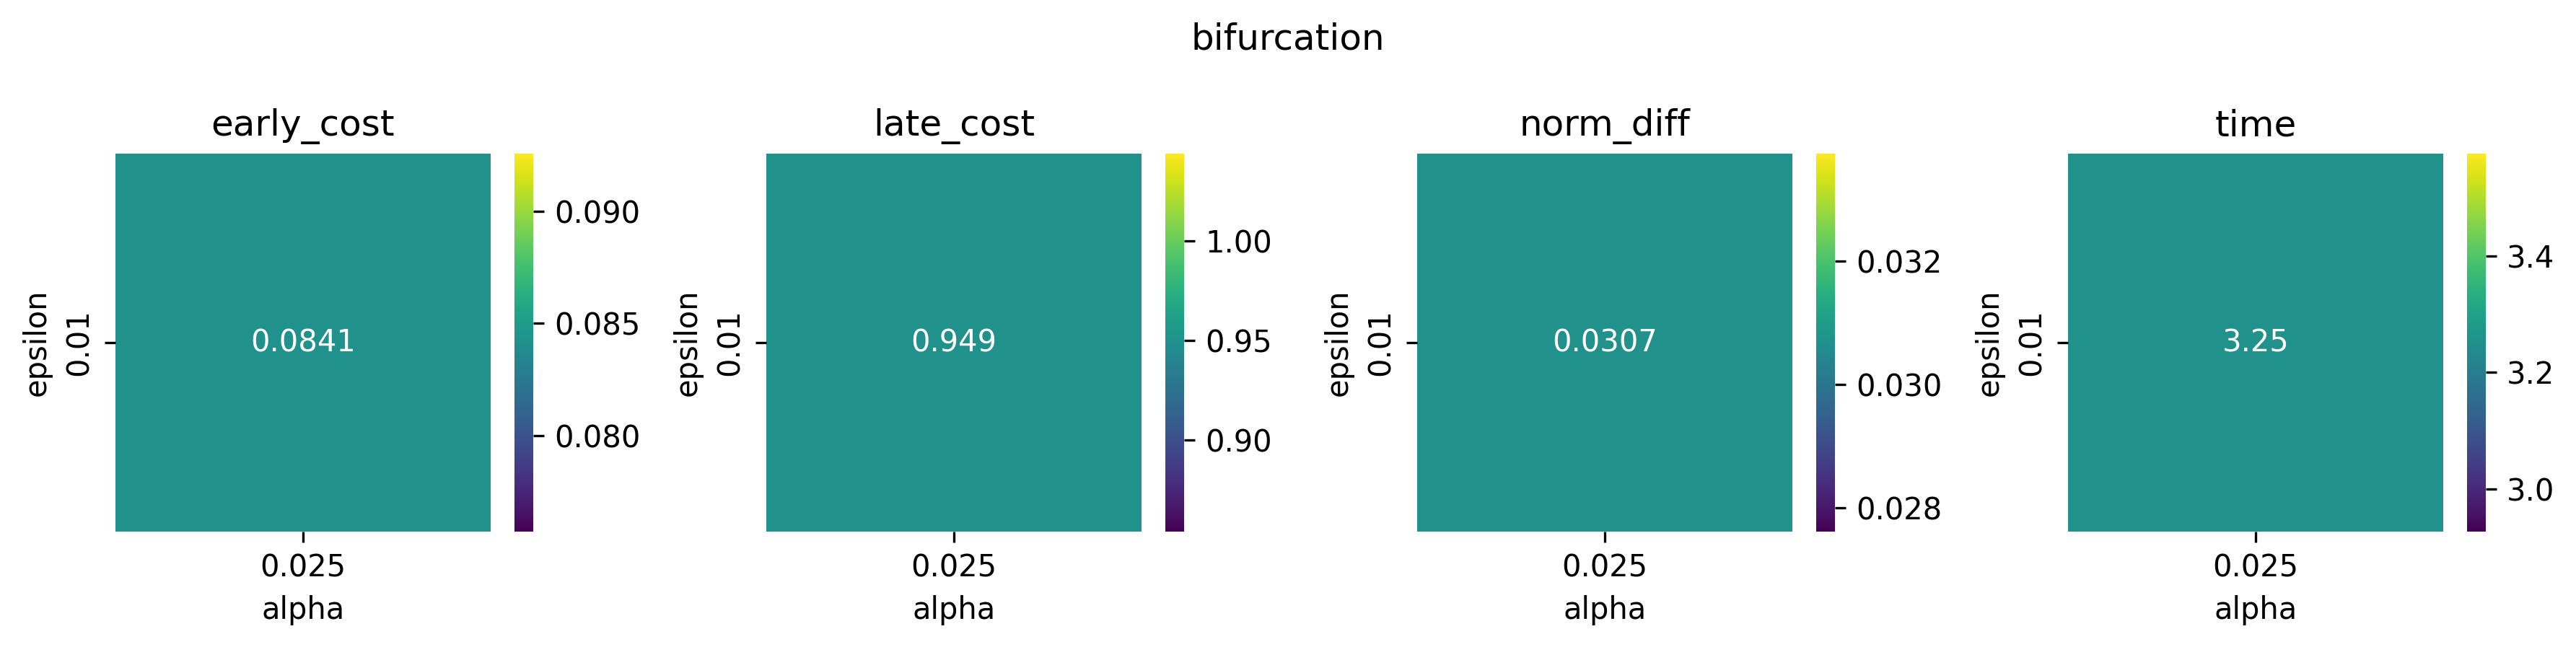

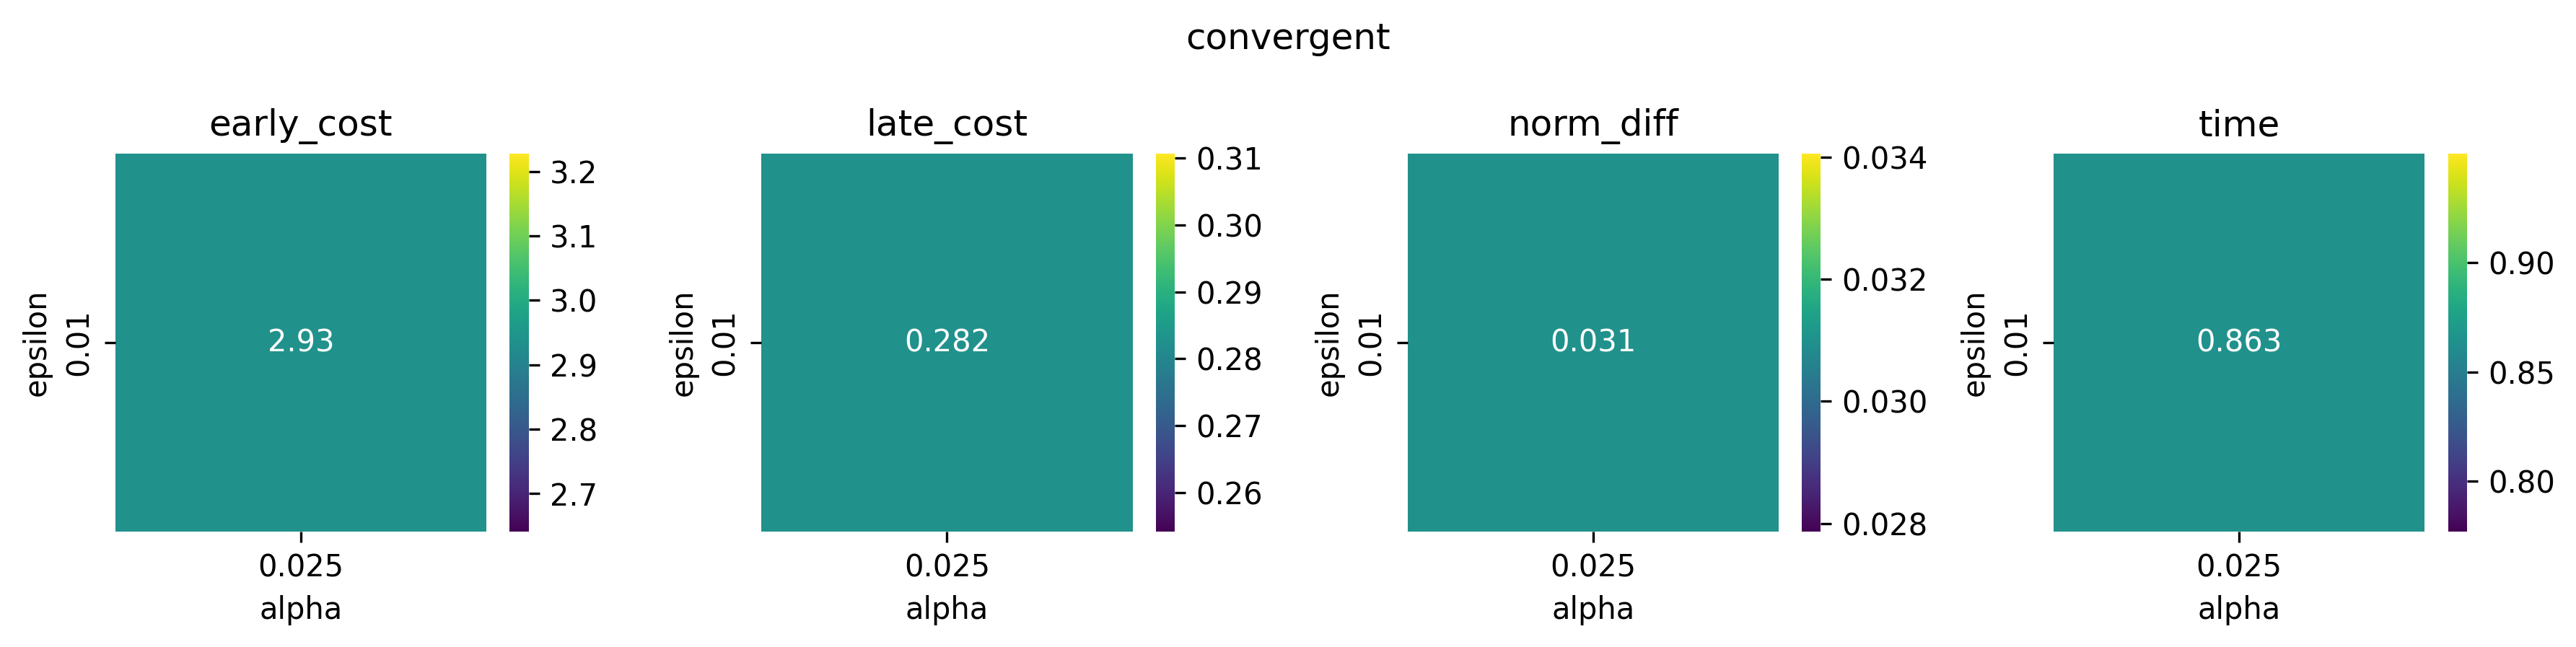

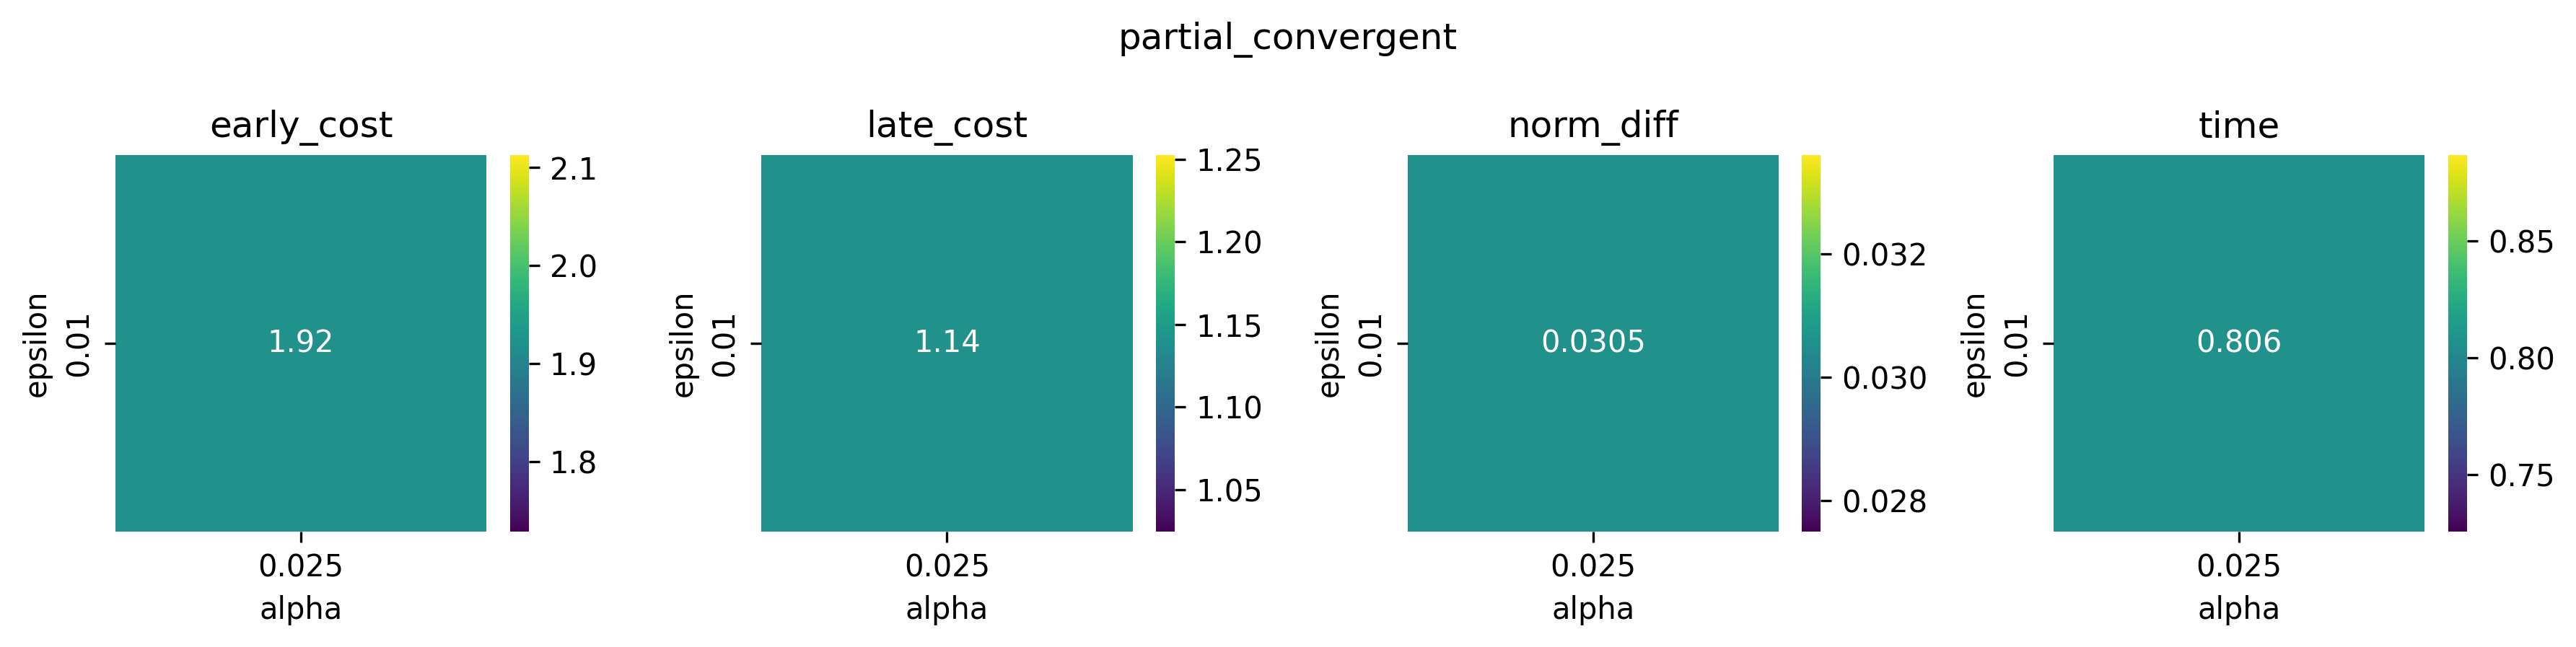

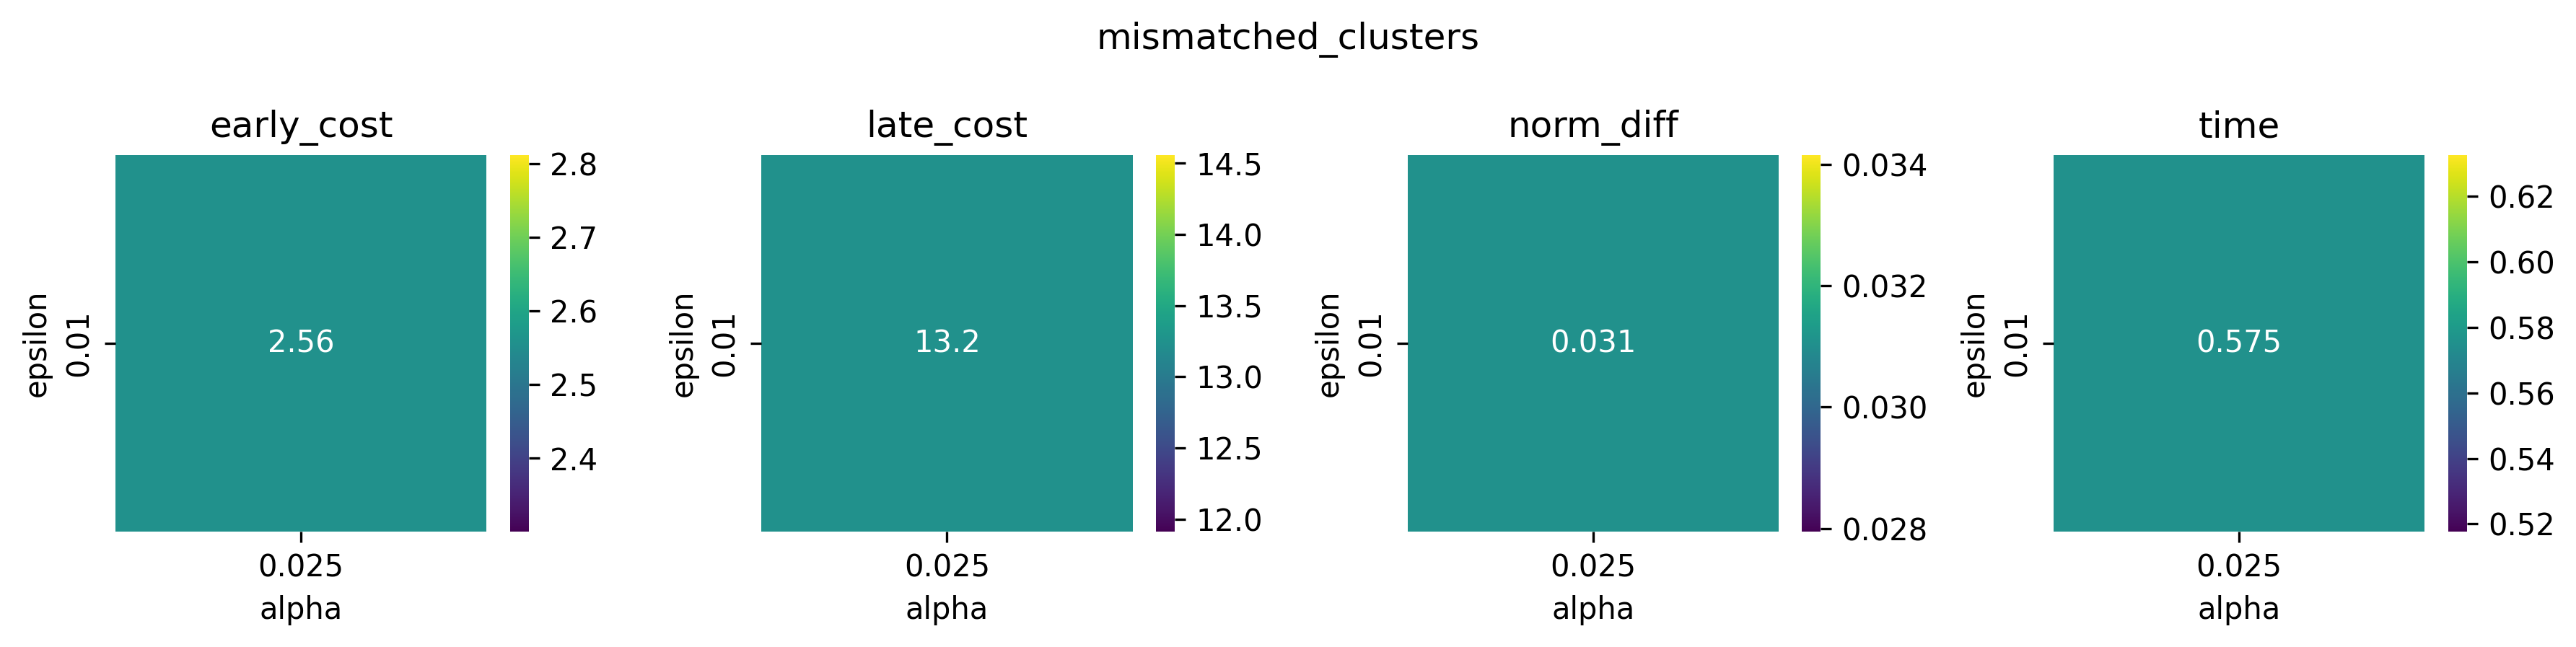

In [10]:
for flow_type in ["bifurcation", "convergent", "partial_convergent", "mismatched_clusters"]:
    s = init_sim(flow_type, plot=False, **sim_params)
    res = gridsearch(s, alphas=alphas, epsilons=epsilons, max_iterations=100, rtol=1e-9, atol=1e-9)
    
    plot(res, suptitle=flow_type)
    with open(f"{flow_type}.pickle", "wb") as fout:
        pickle.dump(res, fout)